In [29]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from pdb import set_trace
from PIL import Image, ImageDraw, ImageFont
from collections import defaultdict
import xml.etree.ElementTree as ET  
import cv2


from detector.Detector import Detector 


In [30]:
FROZEN_GRAPH_PATH = 'C:/Users/iApp/Desktop/projects/object-detection/models/research/object_detection/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb'
LABEL_MAP_PATH = 'C:/Users/iApp/Desktop/projects/object-detection/models/research/object_detection/data/mscoco_label_map.pbtxt'
TEST_IMAGES_DIR_PATH =  'C:/Users/iApp/Desktop/projects/lp-ocr-preprocessing/cropped_lps/gs-testset/'
TEST_RESULT_DIR = None
TESTSET_RATIO = 1


# Detection

In [31]:
def sort_detections_left_to_right(single_image_detections):
    return sorted(single_image_detections, key=lambda x: x['box'][0])

### Do Detection Here

In [34]:
if TESTSET_RATIO > 1:
    TESTSET_RATIO = 1
elif TESTSET_RATIO < 0:
    TESTSET_RATIO = 0
    
TEST_IMAGE_PATHS =  [f for f in glob.glob(TEST_IMAGES_DIR_PATH + '*.jpg')]
n_testset = int(len(TEST_IMAGE_PATHS) * TESTSET_RATIO)
np.random.seed(42)
np.random.shuffle(TEST_IMAGE_PATHS)
TEST_IMAGE_PATHS = TEST_IMAGE_PATHS[:n_testset]

#TEST_IMAGE_PATHS = TEST_IMAGE_PATHS[:1]

all_images_detections = {}
with Detector(FROZEN_GRAPH_PATH, LABEL_MAP_PATH) as detector:
    for image_path in TEST_IMAGE_PATHS: 
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Sort detections left-to-right
        single_image_detections = sort_detections_left_to_right(detector.detect(image, maxDetection=8))

        # Validate detection before add


        # Append to detections list
        image_name = os.path.basename(image_path).split('.')[0]
        all_images_detections[image_name] = single_image_detections

In [35]:
# Construct Ground Truth of all images
all_images_ground_truths = {}

for image_name, _ in all_images_detections.items():
    
    xml_path = os.path.join(TEST_IMAGES_DIR_PATH, image_name + '.xml')
    
    single_image_ground_truths = []
    
    tree = ET.parse(xml_path)
    object_elem_list = tree.getroot().findall('object')
    for object_elem in object_elem_list:    
        ground_truth = {}
        bndbox_elem = object_elem.find('bndbox')

        xmin = int(float(bndbox_elem.find('xmin').text))
        ymin = int(float(bndbox_elem.find('ymin').text))
        xmax = int(float(bndbox_elem.find('xmax').text))
        ymax = int(float(bndbox_elem.find('ymax').text))

        name = object_elem.find('name').text
        
        ground_truth['box'] = (xmin, ymin, xmax, ymax)
        ground_truth['label'] = name
        ground_truth['score'] = None

        single_image_ground_truths.append(ground_truth) 
    single_image_ground_truths = sort_detections_left_to_right(single_image_ground_truths)    
    all_images_ground_truths[image_name] = single_image_ground_truths

### Calculate exact matched recall

In [28]:
def recall_of_all_images(all_images_ground_truths, all_images_detections):
    count = 0
    for image_name, single_image_ground_truths in all_images_ground_truths.items():
        gt_label = list(map(lambda gt: gt['label'], single_image_ground_truths))
        det_label = list(map(lambda det: det['label'], all_images_detections[image_name]))
        count += (gt_label == det_label)

    return count / len(all_images_ground_truths)
all_images_recall = recall_of_all_images(all_images_ground_truths, all_images_detections)
print(f"Model can recalls          {all_images_recall*100:.1f}% of images")

Model can recalls          0.0% of images


In [ ]:
set_trace()

### Calculate TP, FP and FN for each class

In [9]:
def total_ground_truths(all_images_ground_truths):
    return sum([len(single_image_ground_truths) for _, single_image_ground_truths in all_images_ground_truths.items()])

def cal_iou(det_box, gt_box):
    intersect_xmin = max([det_box[0], gt_box[0]])
    intersect_ymin = max([det_box[1], gt_box[1]])
    intersect_xmax = min([det_box[2], gt_box[2]])
    intersect_ymax = min([det_box[3], gt_box[3]])
    
    intersect_area = max(0, intersect_xmax - intersect_xmin + 1) * max(0, intersect_ymax - intersect_ymin + 1)
    
    det_box_area = (det_box[2] - det_box[0] + 1) * (det_box[3] - det_box[1] + 1)
    gt_box_area = (gt_box[2] - gt_box[0] + 1) * (gt_box[3] - gt_box[1] + 1)
    
    iou = intersect_area / float(det_box_area + gt_box_area - intersect_area)
    
    return iou

In [10]:
iou_threshold = 0.5

for image_name, single_image_detections in all_images_detections.items():
    single_image_ground_truths = all_images_ground_truths[image_name].copy()
    
    for det in single_image_detections:
        not_found = True
        for gt in single_image_ground_truths:
            iou = cal_iou(det['box'], gt['box'])
            if iou >= iou_threshold:
                det['actual'] = gt['label']
                not_found = False
                break  
                
        if not_found:        
            det['actual'] = 'NA'     

for image_name, single_image_ground_truths in all_images_ground_truths.items():
    single_image_detection = all_images_detections[image_name].copy()
    
    for gt in single_image_ground_truths:
        not_found = True
        for det in single_image_detection:
            iou = cal_iou(gt['box'], det['box'])
            if iou >= iou_threshold:
                gt['predict'] = det['label']
                not_found = False
                break  
                
        if not_found:        
            gt['predict'] = 'NA'                

### TP, FP and FN

In [12]:
n_correct_detection = sum([det['label'] == det['actual'] for _, single_image_detections in all_images_detections.items() for det in single_image_detections])
n_wrong_detection = sum([det['label'] != det['actual'] for _, single_image_detections in all_images_detections.items() for det in single_image_detections])
n_undetected = sum([gt['label'] != gt['predict'] for _, single_image_ground_truths in all_images_ground_truths.items() for gt in single_image_ground_truths])

#### All classes Recall

In [13]:
recall_score = n_correct_detection / total_ground_truths(all_images_ground_truths)
print(f"Model correctly recalls about       {recall_score*100:.1f}% of chars" )

Model correctly recalls about       0.0% of chars


#### All classes Precision 

In [14]:
true_positive_rate = n_correct_detection / (n_correct_detection + n_wrong_detection)
false_positive_rate = n_wrong_detection / (n_correct_detection + n_wrong_detection)
print(f"Model True Positive Rate(Precision) {true_positive_rate*100:.1f}% of chars")
print(f"Model False Positive Rate           {false_positive_rate*100:.1f}% of chars")

Model True Positive Rate(Precision) 0.0% of chars
Model False Positive Rate           100.0% of chars


### Error Analysis

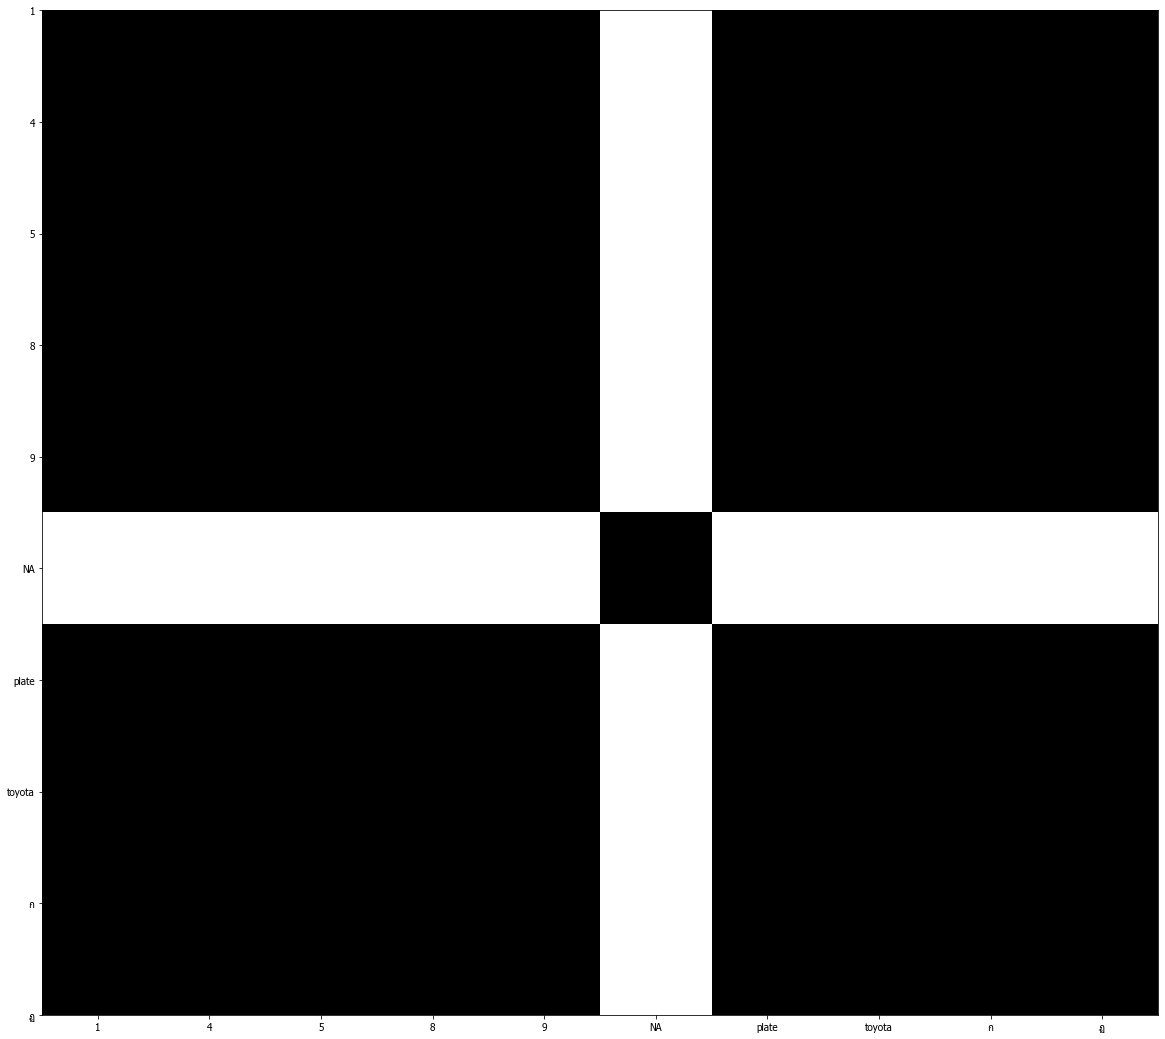

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
%matplotlib inline

gts_dets = np.array([[gt['label'], gt['predict']] for _, single_image_ground_truths in all_images_ground_truths.items() for gt in single_image_ground_truths])

labels = set(gts_dets[:, 0])
labels.update(gts_dets[:, 1])
labels = sorted(list(labels))
le = LabelEncoder()
le.fit(labels)

conf_mx = confusion_matrix(gts_dets[:, 0], 
                           gts_dets[:, 1], 
                           labels=labels)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plt.figure(figsize=(20,20))
plt.imshow(norm_conf_mx, cmap='gray')
plt.xticks(np.arange(len(labels)), labels=labels, family='Tahoma')
plt.yticks(np.arange(len(labels)), labels=labels, family='Tahoma')
plt.show()


### Draw Result

In [25]:
def draw_detection(out_dir, image_path, detections, font, display_label=True):
    image_name = os.path.basename(image_path).split('.')[0]
    
    cleaned_image = Image.open(image_path)
    if cleaned_image.mode != 'RGB':
        cleaned_image = cleaned_image.convert('RGB')
    cleaned_image_drawer = ImageDraw.Draw(cleaned_image)    
    
    for det in detections:
        label = det['label']
        xmin, ymin, xmax, ymax = det['box']
        cleaned_image_drawer.line([(xmin, ymin), 
                                   (xmax, ymin),
                                   (xmax, ymax),
                                   (xmin, ymax),
                                   (xmin, ymin)], fill=(255, 0, 0), width=2)
        if display_label:
            cleaned_image_drawer.text((xmin + (xmax - xmin) / 2, ymax), label, fill=(255,0,0), font=font)
    cleaned_image.save(os.path.join(out_dir, f'{image_name}.jpg'))

# Define font
font_path = 'C:/Users/iApp/Desktop/projects/object-detection/models/research/object_detection/utils/fonts/angsa.ttf'
font = ImageFont.truetype(font_path, 18)


In [ ]:
# Draw True Positive
correct_detection_dir = os.path.join(TEST_RESULT_DIR, 'correct_detection')
if not os.path.exists(correct_detection_dir):
    os.makedirs(correct_detection_dir)
    
for image_name, single_image_detections in all_images_detections.items():
    image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, image_name + '.jpg')
    detections_to_draw = [detection for detection in single_image_detections if detection['label'] == detection['actual']]
    if len(detections_to_draw) > 0:
        draw_detection(correct_detection_dir, image_path, detections_to_draw, font)

In [ ]:
# Draw False Positive
wrong_detection_dir = os.path.join(TEST_RESULT_DIR, 'wrong_detection')
#if not os.path.exists(wrong_detection_dir):
#    os.makedirs(wrong_detection_dir)
    
for image_name, single_image_detections in all_images_detections.items():
    image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, image_name + '.jpg')
    wrong_detections = [detection for detection in single_image_detections if detection['label'] != detection['actual']]
    if len(wrong_detections) > 0:
        for wrong_detection in wrong_detections:
            if wrong_detection['actual'] == 'NA':
                out_dir = os.path.join(wrong_detection_dir, 'NA')
            else:
                out_dir = os.path.join(wrong_detection_dir, str(ord(wrong_detection['actual'])), str(ord(wrong_detection['label'])))
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            draw_detection(out_dir, image_path, [wrong_detection], font)

In [ ]:
wrong_detection

In [ ]:
# Draw False Negative
undetected_dir = os.path.join(TEST_RESULT_DIR, 'undetected')

for image_name, single_image_ground_truths in all_images_ground_truths.items():
    image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, image_name + '.jpg')
    gts_to_draw = [gt for gt in single_image_ground_truths if gt['predict'] == 'NA']
    if len(gts_to_draw) > 0:
        for gt in gts_to_draw:
            out_dir = os.path.join(undetected_dir, str(ord(gt['label'])))
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            draw_detection(out_dir, image_path, [gt], font, display_label=False)

In [ ]:
# Draw All Detection
all_detections_dir = os.path.join(TEST_RESULT_DIR, 'all_detection')
if not os.path.exists(all_detections_dir):
    os.makedirs(all_detections_dir)
for image_name, single_image_detections in all_images_detections.items():
    image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, image_name + '.jpg')
    draw_detection(all_detections_dir, image_path, single_image_detections, font) 